# Team Project : Computer Vision

# Project Title : An image Processing Pipeline for Satellite Image Enhancement and Creation of Classification and Segmentation Maps for Land Use/Urban Planning using CNN and Transfer Learning.

# Team Members : Nitin, Puneet & Rohan.

# Datasets : RGB EuroSAT and Landcover.ai

# Code Notebook 1 : This note book is used to carry out the following tasks

# 1. Load the Data Set
# 2. EDA and Preprocessing
# 3. Model Creation and Training.
# 4. Validation and Performance metrics.

# For the Application case, the best performing classification model is taken and modified to carry out segmentation on  the same images as described in #5


#5 The best performing model is taken and used for creating land use classification maps for Bangalore Urban. The Test Image is taken from Google Earth Engine. This part is discussed in the seperate Code Notebook.

# Part 1 : DataSet Loading & EDA

Train size: 18900, Validation size: 4050, Test size: 4050


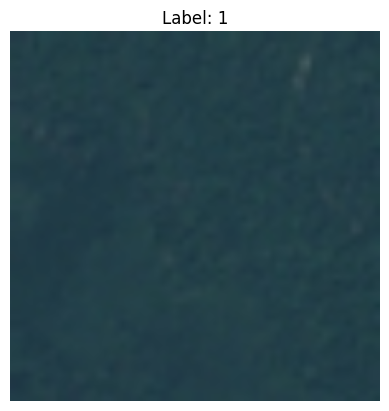

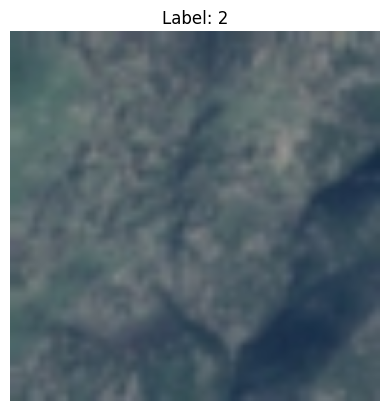

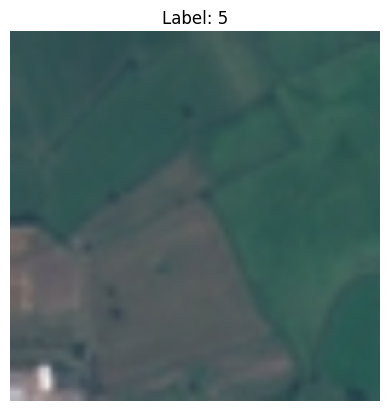

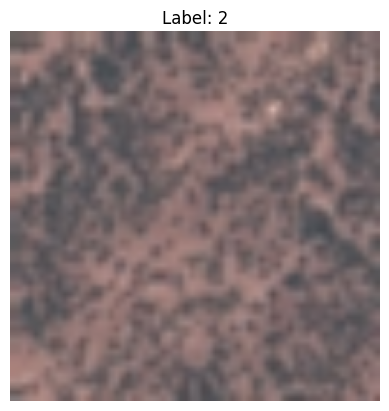

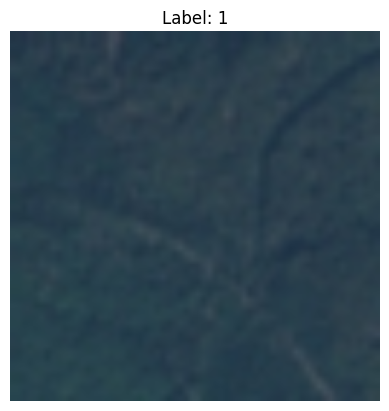

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load the EuroSAT dataset directly from TensorFlow Datasets
dataset, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)

# Retrieve the full dataset
full_dataset = dataset['train']  # All data is in the 'train' split
num_examples = info.splits['train'].num_examples

# Define split sizes
train_size = int(0.7 * num_examples)
val_size = int(0.15 * num_examples)
test_size = num_examples - train_size - val_size

# Shuffle the dataset
#full_dataset = full_dataset.shuffle(num_examples, seed=42)

# Split the dataset
train_ds = full_dataset.take(train_size)
remaining_ds = full_dataset.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

# Preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize for models like VGG
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image, label

# Apply preprocessing and batching
train_ds = train_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

# Inspect splits
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

# Visualize a few samples
import matplotlib.pyplot as plt

for image, label in train_ds.take(5):
    plt.figure()
    plt.imshow(image[0].numpy())
    plt.title(f"Label: {label[0].numpy()}")
    plt.axis("off")
    plt.show()

In [ ]:
# Extract class labels from the info object
class_labels = info.features['label'].names

# Display the class labels
print("Class Labels:", class_labels)

Class Labels: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


# Class Distribution with Class Labels

C:\Users\nitin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


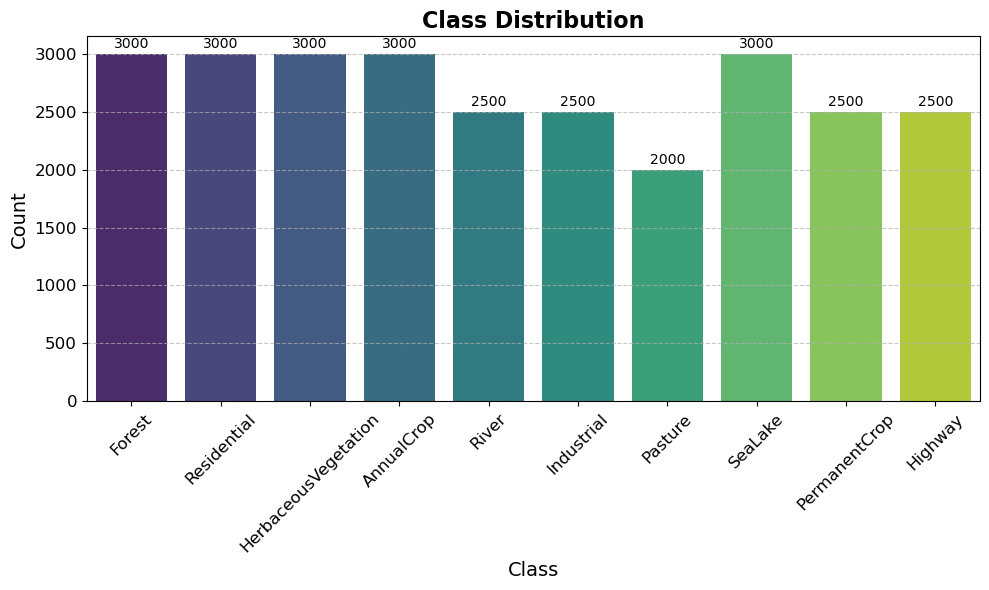

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

# Load dataset and info
dataset, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)

# Retrieve class labels
class_labels = info.features['label'].names

# Count class distribution
class_counts = {}
for _, label in tfds.as_numpy(dataset['train']):
    class_counts[label] = class_counts.get(label, 0) + 1

# Prepare data for plotting
class_names = [class_labels[i] for i in class_counts.keys()]
counts = [class_counts[i] for i in class_counts.keys()]

# Create a modern barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=counts, palette='viridis')

# Add labels and formatting
plt.title('Class Distribution', fontsize=16, weight='bold')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate counts above bars
for i, count in enumerate(counts):
    plt.text(i, count + 50, str(count), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Sample Images with Class Names

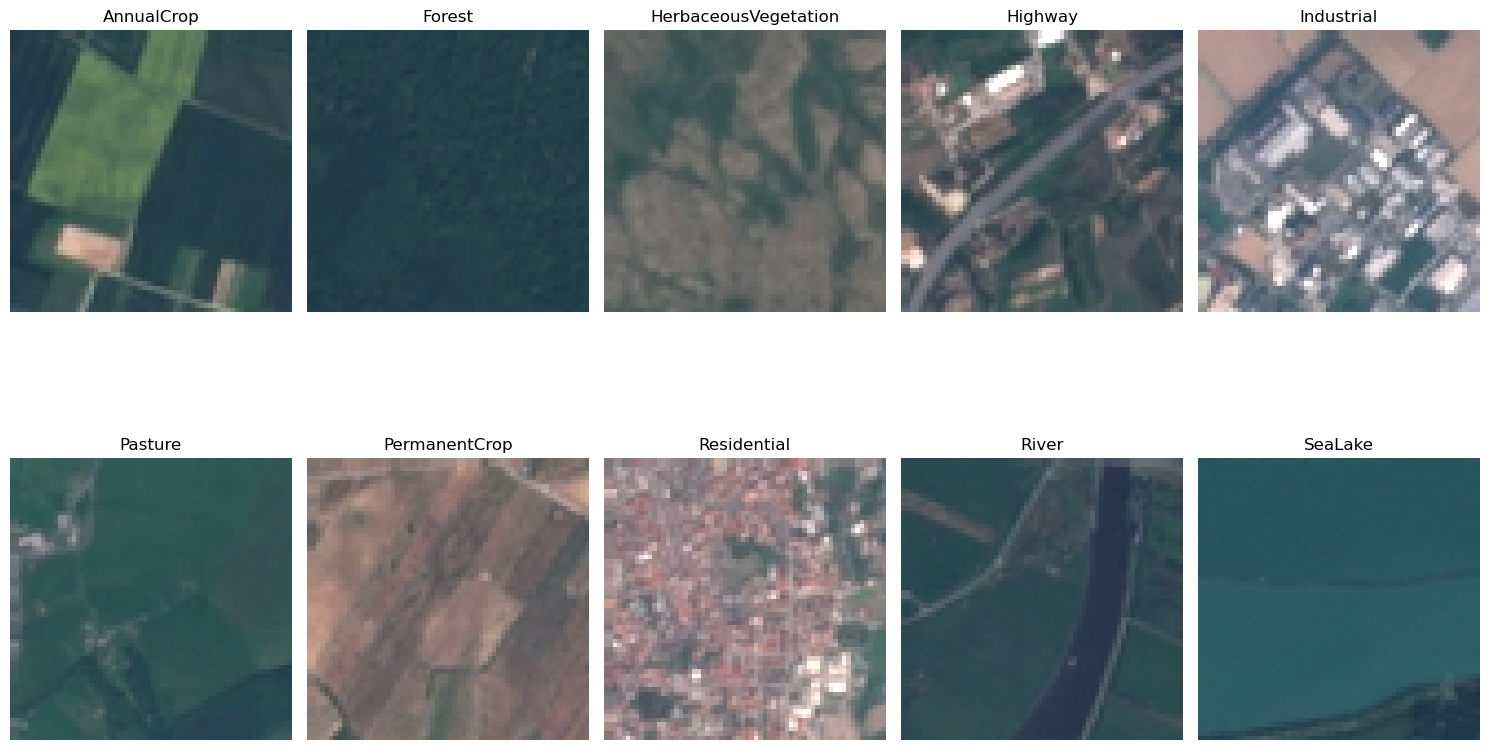

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the dataset
dataset, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)

# Retrieve class labels
class_labels = info.features['label'].names

# Collect one sample per class
samples_per_class = {class_name: None for class_name in class_labels}
for image, label in tfds.as_numpy(dataset['train']):
    class_name = class_labels[label]
    if samples_per_class[class_name] is None:
        samples_per_class[class_name] = image
    if all(value is not None for value in samples_per_class.values()):
        break

# Plot images in a grid
num_classes = len(class_labels)
cols = 5  # Number of columns in the grid
rows = (num_classes // cols) + (num_classes % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

for idx, (class_name, image) in enumerate(samples_per_class.items()):
    row, col = divmod(idx, cols)
    ax = axes[row, col]
    ax.imshow(image)
    ax.set_title(class_name, fontsize=12)
    ax.axis('off')

# Remove empty axes if classes are fewer than grid spaces
for idx in range(num_classes, rows * cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()

# Pixel Intensity Distribution by Class

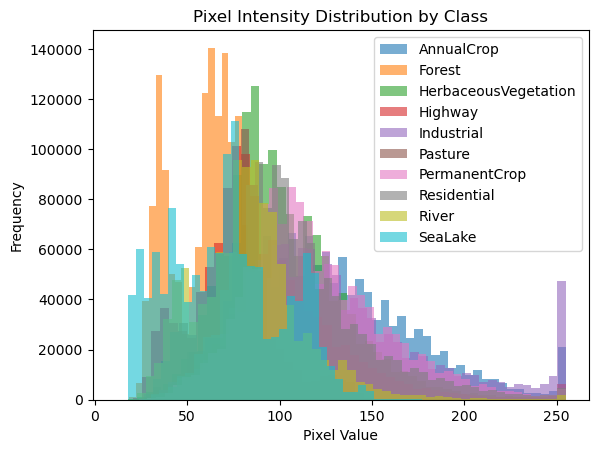

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

# Load the dataset
dataset, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)

# Retrieve class labels
class_labels = info.features['label'].names

# Collect pixel intensities for each class
pixel_intensities = {label: [] for label in class_labels}
for image, label in tfds.as_numpy(dataset['train'].take(1000)):  # Use a subset for efficiency
    pixel_intensities[class_labels[label]].extend(image.flatten())

# Plot histograms for each class
for class_name, pixels in pixel_intensities.items():
    plt.hist(pixels, bins=50, alpha=0.6, label=class_name)

plt.title('Pixel Intensity Distribution by Class')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Inter-Class Similarity Analysis using Structural Similarity Index (SSIM)

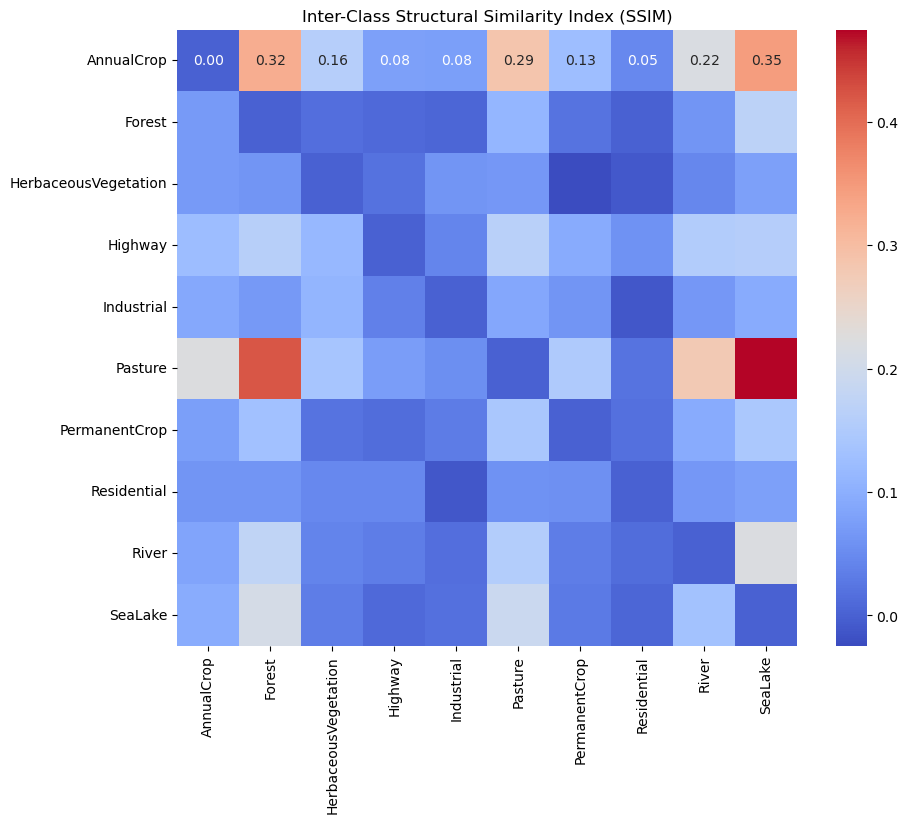

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def compute_similarity(image1, image2):
    # Convert images to grayscale
    image1_gray = np.mean(image1, axis=-1)
    image2_gray = np.mean(image2, axis=-1)

    # Specify data range based on image values (normalized images typically have range [0, 1])
    return ssim(image1_gray, image2_gray, data_range=image1_gray.max() - image1_gray.min())

# Select representative samples
samples = {}
for image, label in tfds.as_numpy(dataset['train']):
    class_name = class_labels[label]
    if class_name not in samples:
        samples[class_name] = image
    if len(samples) == len(class_labels):
        break

# Compute SSIM for pairs of classes
similarity_matrix = np.zeros((len(class_labels), len(class_labels)))
for i, class1 in enumerate(class_labels):
    for j, class2 in enumerate(class_labels):
        if i != j:
            similarity_matrix[i, j] = compute_similarity(samples[class1], samples[class2])

# Visualize the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", xticklabels=class_labels, yticklabels=class_labels, cmap="coolwarm")
plt.title("Inter-Class Structural Similarity Index (SSIM)")
plt.show()

# Augmentation Planning for Class Imbalance

Class Percentages: {'Forest': 11.11111111111111, 'Residential': 11.11111111111111, 'HerbaceousVegetation': 11.11111111111111, 'AnnualCrop': 11.11111111111111, 'River': 9.25925925925926, 'Industrial': 9.25925925925926, 'Pasture': 7.4074074074074066, 'SeaLake': 11.11111111111111, 'PermanentCrop': 9.25925925925926, 'Highway': 9.25925925925926}


C:\Users\nitin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


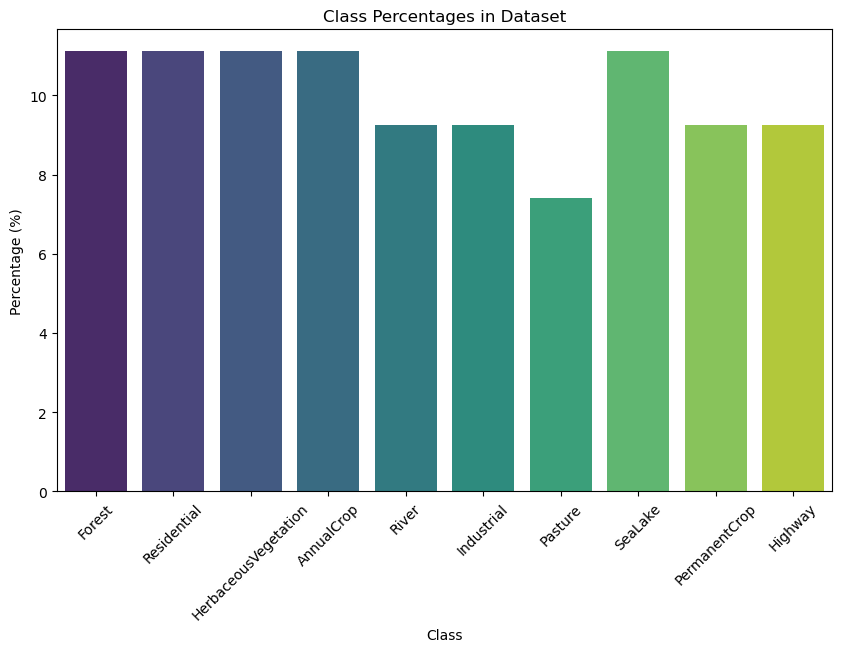

In [ ]:
# Bar plot for class distribution (already done earlier)
# Add over/under-representation analysis
total_samples = sum(class_counts.values())
class_percentages = {class_labels[i]: (count / total_samples) * 100 for i, count in class_counts.items()}

print("Class Percentages:", class_percentages)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_percentages.keys()), y=list(class_percentages.values()), palette="viridis")
plt.title("Class Percentages in Dataset")
plt.ylabel("Percentage (%)")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.show()


# Color and Texture Analysis

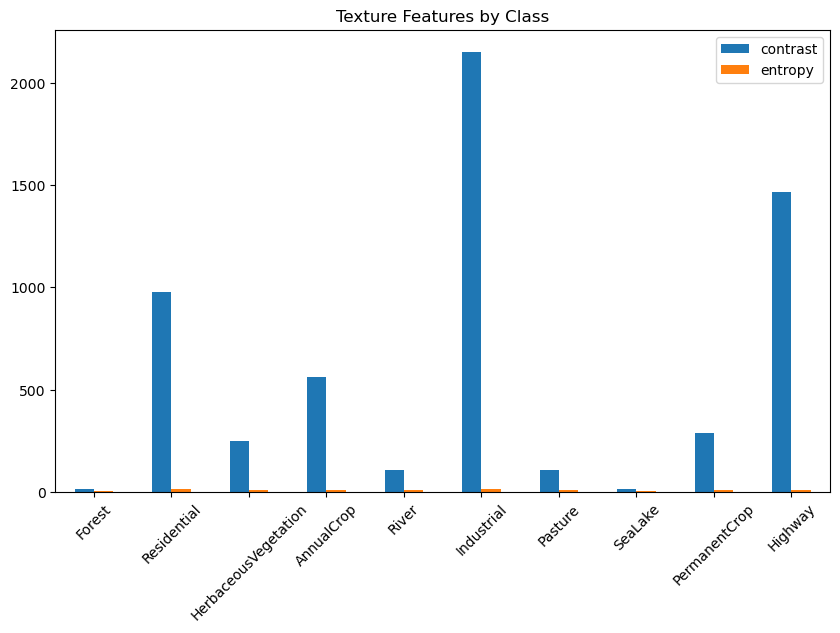

In [ ]:
from skimage.feature import graycomatrix, graycoprops
import pandas as pd

def compute_texture_features(image, distances=[5], angles=[0]):
    # Convert to grayscale
    gray_image = np.mean(image, axis=-1).astype(np.uint8)
    glcm = graycomatrix(gray_image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    entropy = -np.sum(glcm * np.log2(glcm + 1e-9))
    return contrast, entropy

# Analyze texture for each class
texture_features = {}
for class_name, image in samples.items():
    contrast, entropy = compute_texture_features(image)
    texture_features[class_name] = {"contrast": contrast, "entropy": entropy}

# Visualize texture features
texture_df = pd.DataFrame(texture_features).T
texture_df.plot(kind="bar", figsize=(10, 6), rot=45, title="Texture Features by Class")
plt.show()

# Feature Space Clustering : PCA or t-SNE on Pixel Values

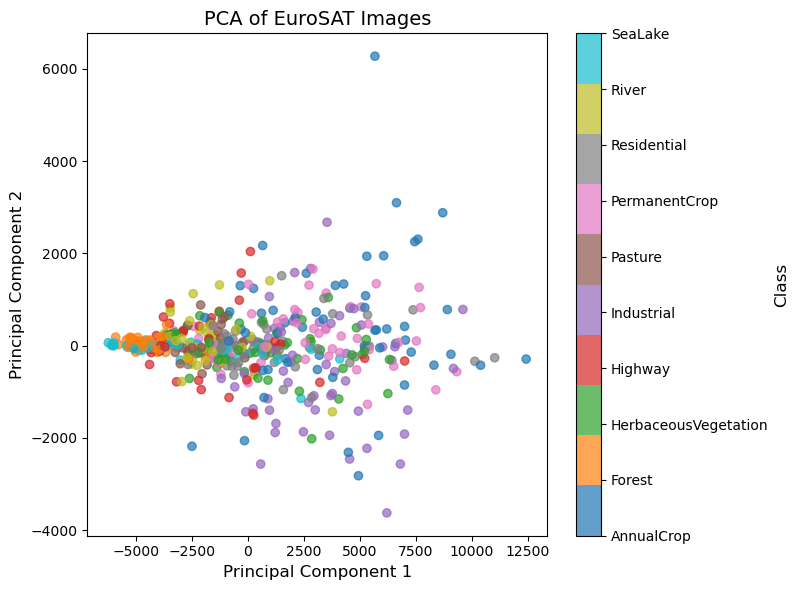

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Flatten images and reduce dimensionality
embeddings, labels = [], []
for image, label in tfds.as_numpy(dataset['train'].take(500)):  # Limit to 500 samples
    embeddings.append(image.flatten())
    labels.append(label)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Map labels (numbers) to class names
class_labels = info.features['label'].names  # Extract class labels from dataset info
mapped_labels = [class_labels[label] for label in labels]

# Visualize PCA results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap="tab10", alpha=0.7)

# Add axis labels
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)

# Add a colorbar with class names
colorbar = plt.colorbar(scatter, ticks=range(len(class_labels)))
colorbar.set_label("Class", fontsize=12)
colorbar.ax.set_yticklabels(class_labels)  # Replace numbers with class names

# Add a title
plt.title("PCA of EuroSAT Images", fontsize=14)

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load the EuroSAT dataset directly from TensorFlow Datasets
dataset, info = tfds.load('eurosat/rgb', with_info=True, as_supervised=True)

# Retrieve the full dataset
full_dataset = dataset['train']  # All data is in the 'train' split
num_examples = info.splits['train'].num_examples

# Define split sizes
train_size = int(0.7 * num_examples)
val_size = int(0.15 * num_examples)
test_size = num_examples - train_size - val_size

# Shuffle the dataset
#full_dataset = full_dataset.shuffle(num_examples, seed=42)

# Split the dataset
train_ds = full_dataset.take(train_size)
remaining_ds = full_dataset.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

# Preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, [64, 64])  # Resize for models like VGG
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image, label

# Apply preprocessing and batching
train_ds = train_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

# Inspect splits
print(f"Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

Train size: 18900, Validation size: 4050, Test size: 4050


# CNN Model Creation and Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the CNN model
model = Sequential()

# Input layer
model.add(Input(shape=(64, 64, 3)))  # Updated input size for EuroSAT

# First convolutional layer with 32 filters and Batch Normalization
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Second convolutional layer with 32 filters and Batch Normalization
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Third convolutional layer with 64 filters and Batch Normalization
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Fourth convolutional layer with 64 filters and Batch Normalization
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

# Flatten the output from the convolutional layers
model.add(Flatten())

# Fully connected layer with 512 nodes and Dropout
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Fully connected layer with 256 nodes and Dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 10 nodes (one for each class)
model.add(Dense(10, activation='softmax'))  # 10 classes for EuroSAT

# Compile the model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │     134,218,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,418,474 (512.77 MB)

 Trainable params: 134,418,090 (512.76 MB)

 Non-trainable params: 384 (1.50 KB)

# Training the CNN

Epoch 1/35
591/591 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.5165 - loss: 1.2797 - val_accuracy: 0.5763 - val_loss: 1.4194 - learning_rate: 5.0000e-05
Epoch 2/35
591/591 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.5176 - loss: 1.2600 - val_accuracy: 0.5854 - val_loss: 1.2623 - learning_rate: 5.0000e-05
Epoch 3/35
591/591 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.5218 - loss: 1.2555 - val_accuracy: 0.6040 - val_loss: 1.1610 - learning_rate: 5.0000e-05
Epoch 4/35
591/591 ━━━━━━━━━━━━━━━━━━━━ 30s 51ms/step - accuracy: 0.5288 - loss: 1.2327 - val_accuracy: 0.5827 - val_loss: 1.2319 - learning_rate: 5.0000e-05
Epoch 5/35
591/591 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - accuracy: 0.5466 - loss: 1.2049 - val_accuracy: 0.5894 - val_loss: 1.1947 - learning_rate: 5.0000e-05
Epoch 6/35
591/591 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - accuracy: 0.5540 - loss: 1.1770 - val_accuracy: 0.5953 - val_loss: 1.1701 - learning_rate: 5.0000e-05
Epoch 7/35
591/591 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/ste

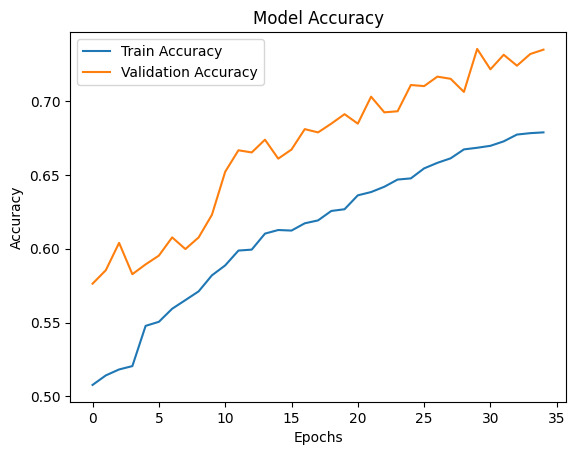

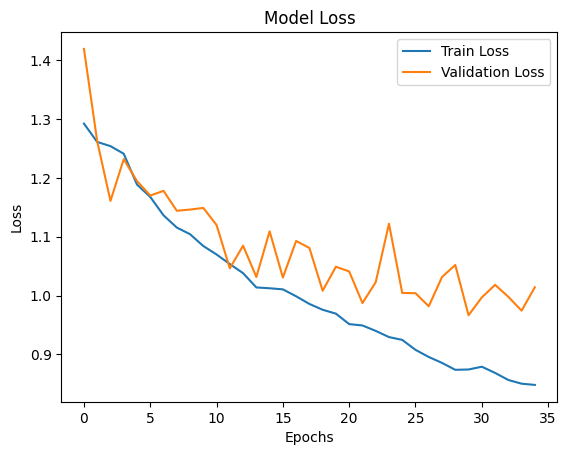

In [ ]:
# Train the model (using preprocessed train_ds and val_ds)
history = model.fit(
    train_ds,  # Preprocessed training dataset
    validation_data=val_ds,  # Preprocessed validation dataset
    epochs=35,
    callbacks=[lr_scheduler]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)  # Preprocessed test dataset
print(f"Test Accuracy: {test_accuracy}")

# Visualize Training History
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Transfer Learning approach with VGG 16 : Unfroze last 4 layers and added custom layers : Ref Assignment 2.1

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the VGG16 model without the top layers (for EuroSAT classification)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last block in VGG16
for layer in vgg_model.layers[-4:]:  # Adjust based on VGG16 architecture
    layer.trainable = True

# Add custom layers for EuroSAT classification on top of VGG16
x = vgg_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Regularization
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)  # 10 classes for EuroSAT

# Combine base VGG16 model and custom layers into a new model
model = Model(inputs=vgg_model.input, outputs=predictions)

# Compile the model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_ds,  # Preprocessed training dataset
    validation_data=val_ds,  # Preprocessed validation dataset
    epochs=20,
    callbacks=[lr_scheduler],
    verbose=1
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 388s 580ms/step - accuracy: 0.2642 - loss: 2.2062 - val_accuracy: 0.1948 - val_loss: 10.0655 - learning_rate: 0.0010
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 350s 492ms/step - accuracy: 0.3589 - loss: 1.5939 - val_accuracy: 0.1047 - val_loss: 44428.0703 - learning_rate: 0.0010
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 286s 483ms/step - accuracy: 0.4136 - loss: 1.4632 - val_accuracy: 0.0919 - val_loss: 9.8755 - learning_rate: 0.0010
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 321s 481ms/step - accuracy: 0.5340 - loss: 1.2568 - val_accuracy: 0.2943 - val_loss: 2.5182 - learning_rate: 0.0010
Epoch 5/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 325s 485ms/step - accuracy: 0.6170 - loss: 1.0668 - val_accuracy: 0.5086 - val_loss: 1.3607 - learning_rate: 0.0010
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 282s 477ms/step - accuracy: 0.6649 - loss: 0.9284 - val_accuracy: 0.5067 - val_loss: 1.4622 - learning_rate: 0.0010
Epoch 7/

# Learn rate for Custom VGG-16 Finetuned Model

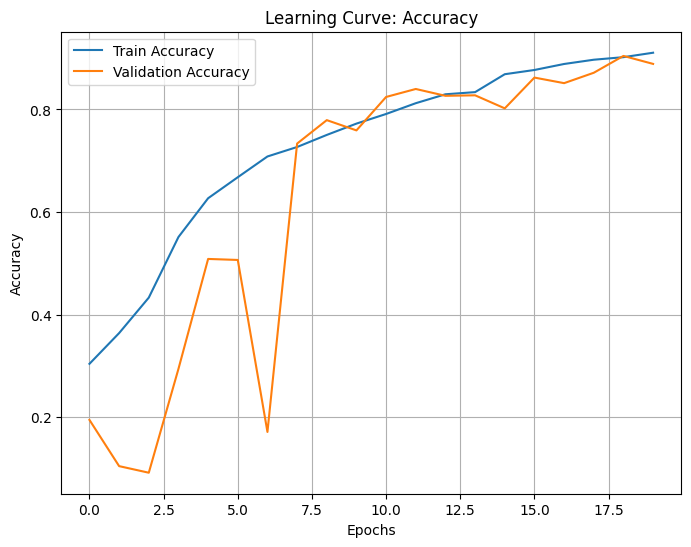

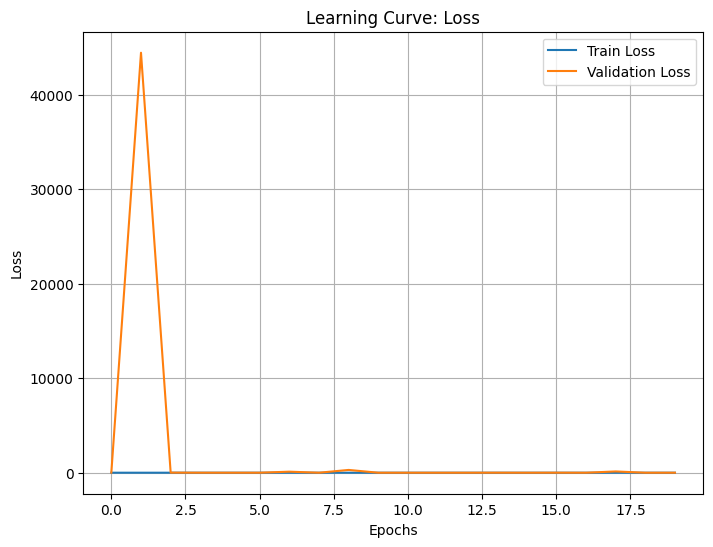

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the save path in Google Drive
model_save_path = '/content/drive/MyDrive/EuroSAT_VGG16_Model.h5'

# Save the model
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to: /content/drive/MyDrive/EuroSAT_VGG16_Model.h5


# Transfer Learning approach with VGG 16 : Unfroze last 4 layers and added custom layers : Ref Assignment 2.1

# Learn Rate lowered to 0.0001

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Load the VGG16 model without the top layers (for EuroSAT classification)
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last block in VGG16
for layer in vgg_model.layers[-4:]:  # Adjust based on VGG16 architecture
    layer.trainable = True

# Add custom layers for EuroSAT classification on top of VGG16
x = vgg_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Regularization
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)  # 10 classes for EuroSAT

# Combine base VGG16 model and custom layers into a new model
model = Model(inputs=vgg_model.input, outputs=predictions)

# Compile the model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_ds,  # Preprocessed training dataset
    validation_data=val_ds,  # Preprocessed validation dataset
    epochs=20,
    callbacks=[lr_scheduler],
    verbose=1
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 310s 509ms/step - accuracy: 0.3277 - loss: 2.1925 - val_accuracy: 0.3768 - val_loss: 2.1037 - learning_rate: 1.0000e-04
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 292s 493ms/step - accuracy: 0.6270 - loss: 1.0851 - val_accuracy: 0.5365 - val_loss: 1.4545 - learning_rate: 1.0000e-04
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 291s 493ms/step - accuracy: 0.7458 - loss: 0.7409 - val_accuracy: 0.7277 - val_loss: 0.8151 - learning_rate: 1.0000e-04
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 296s 502ms/step - accuracy: 0.8571 - loss: 0.4558 - val_accuracy: 0.9032 - val_loss: 0.3164 - learning_rate: 1.0000e-04
Epoch 5/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 296s 501ms/step - accuracy: 0.9129 - loss: 0.3005 - val_accuracy: 0.9286 - val_loss: 0.2366 - learning_rate: 1.0000e-04
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 296s 500ms/step - accuracy: 0.9298 - loss: 0.2404 - val_accuracy: 0.9314 - val_loss: 0.2131 - learning_rate: 1.0000e-04
Epoch 7/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 

# Learning Curve

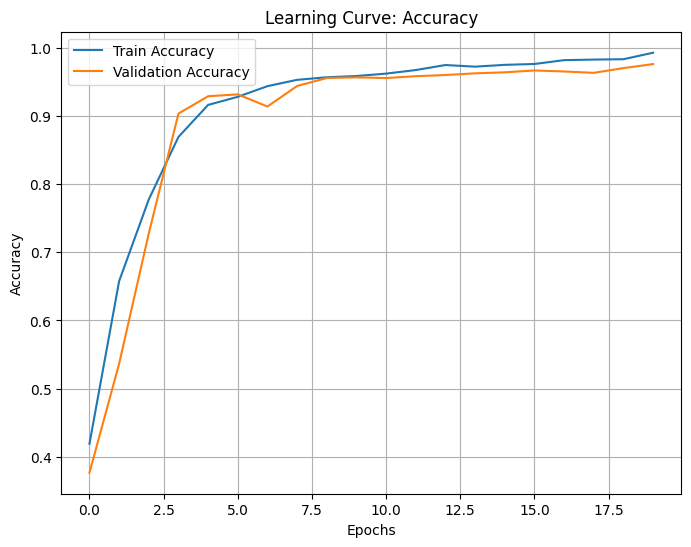

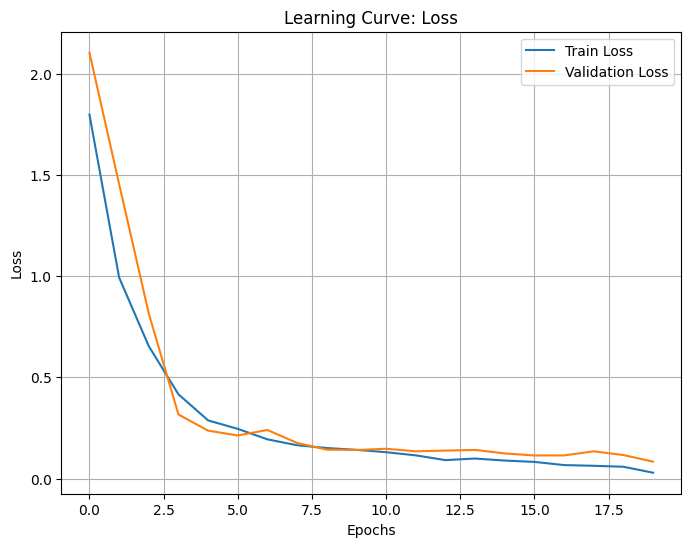

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Save the model in the native Keras format (.keras)
model_save_path = '/content/drive/MyDrive/EuroSAT_VGG16_Model.keras'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")



Model saved to: /content/drive/MyDrive/EuroSAT_VGG16_Model.keras


In [ ]:
from tensorflow.keras.models import load_model

# Define the load path
model_load_path = '/content/drive/MyDrive/EuroSAT_VGG16_Model'

# Load the model
loaded_model = load_model(model_load_path)
print("Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to: /content/drive/MyDrive/EuroSAT_VGG16_Model.h5


# Transfer Learning approach with ResNET50 : Unfroze last 10 layers and added custom layers : Ref Assignment 2.1

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt

# Custom callback to log learning rate at the end of each epoch
class LearningRateLogger(Callback):
    def on_train_begin(self, logs=None):
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr.numpy() if hasattr(self.model.optimizer, 'lr') else 0
        self.learning_rates.append(lr)

# Load the ResNet50 model without the top layers (for EuroSAT classification)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-10:]:  # Adjust number of layers as needed
    layer.trainable = True

# Add custom layers for EuroSAT classification on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Reduced dense layer
x = BatchNormalization()(x)            # Added Batch Normalization
x = Dropout(0.3)(x)                    # Optional Dropout
x = Dense(128, activation='relu')(x)   # Further reduced dense layer
x = BatchNormalization()(x)            # Added Batch Normalization
predictions = Dense(10, activation='softmax')(x)  # 10 classes for EuroSAT

# Combine base ResNet50 model and custom layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower initial learning rate
optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Instantiate the learning rate logger and learning rate scheduler
lr_logger = LearningRateLogger()
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model using the EuroSAT preprocessed datasets
history = model.fit(
    train_ds,  # Preprocessed training dataset
    validation_data=val_ds,  # Preprocessed validation dataset
    epochs=20,
    callbacks=[lr_scheduler, lr_logger],  # Add both callbacks here
    verbose=1
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plotting function for learning curves and learning rate
def plot_learning_curves(history, lr_logger):
    # Retrieve metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    lr = lr_logger.learning_rates  # Use the learning rates from the custom callback

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot learning rate
    plt.subplot(1, 3, 3)
    plt.plot(epochs, lr, 'g-', label='Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 272s 350ms/step - accuracy: 0.8145 - loss: 0.6033 - val_accuracy: 0.1089 - val_loss: 15.7475 - learning_rate: 5.0000e-04
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 185s 314ms/step - accuracy: 0.9313 - loss: 0.2073 - val_accuracy: 0.6583 - val_loss: 1.5325 - learning_rate: 5.0000e-04
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 178s 301ms/step - accuracy: 0.9568 - loss: 0.1305 - val_accuracy: 0.7365 - val_loss: 0.8121 - learning_rate: 5.0000e-04
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 179s 303ms/step - accuracy: 0.9649 - loss: 0.1095 - val_accuracy: 0.7649 - val_loss: 0.8860 - learning_rate: 5.0000e-04
Epoch 5/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 178s 300ms/step - accuracy: 0.9713 - loss: 0.0873 - val_accuracy: 0.8240 - val_loss: 0.6093 - learning_rate: 5.0000e-04
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 186s 315ms/step - accuracy: 0.9792 - loss: 0.0620 - val_accuracy: 0.5069 - val_loss: 2.2454 - learning_rate:

# Model Summary for Fintuned ResNET50

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 72,336,160 (275.94 MB)

 Trainable params: 24,094,090 (91.91 MB)

 Non-trainable params: 53,888 (210.50 KB)

 Optimizer params: 48,188,182 (183.82 MB)

# Learning Rate

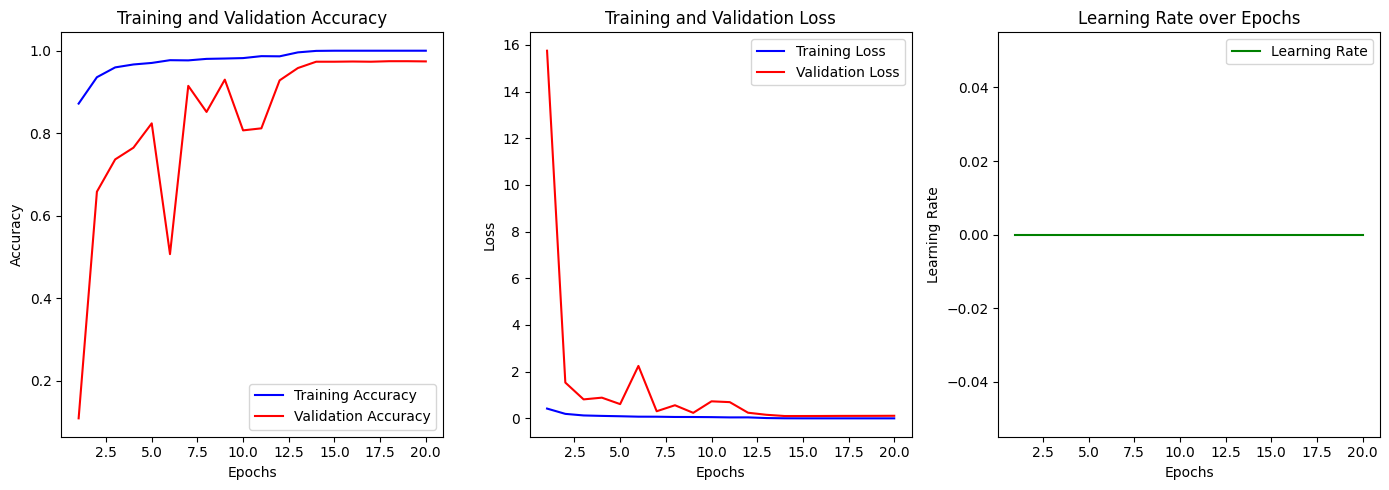

In [ ]:
# Plot the learning curves using the updated function and the logged learning rates
plot_learning_curves(history, lr_logger)

In [ ]:
# Save the model in the native Keras format (.keras)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the save path in Google Drive
model_save_path = '/content/drive/MyDrive/EuroSAT_ResNet50_Model.keras'

model.save(model_save_path)
print(f"Model saved to: {model_save_path}")


Mounted at /content/drive
Model saved to: /content/drive/MyDrive/EuroSAT_ResNet50_Model.keras


# This Part deals with Modifying the Custom VGG-16 Model Trained for the above classification task.

# Idea is to Attempt Segmenation of the 10m and 3m Resolution RGB Imagery of Bangalore obtained from Google Earth Engine.

# The Application part is done in a seperate Code Notebook

# loading the Modified VGG-16 Based model that we created Earlier.

In [16]:
# Save the model in the native Keras format (.keras)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#EuroSAT_VGG16_Model.keras

from tensorflow.keras.models import load_model

# Define the load path
model_load_path = '/content/drive/MyDrive/EuroSAT_VGG16_Model.keras'

# Load the model
Base_Model = load_model(model_load_path)
print("Model loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 38 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
Base_Model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 42,345,622 (161.54 MB)

 Trainable params: 21,172,426 (80.77 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 21,172,428 (80.77 MB)

#Steps to Modify the Model for Segmentation:

1. Remove Fully Connected Layers: The Flatten and Dense layers will be removed since segmentation requires a fully convolutional architecture.

2. Add Decoder Layers: Use transposed convolution layers (Conv2DTranspose) or upsampling layers (UpSampling2D with Conv2D) to progressively increase the spatial resolution of the feature maps back to the original image size.

3. Skip Connections (Optional): To preserve spatial details, you can use skip connections from earlier layers (as in U-Net) and concatenate them with the upsampled feature maps.

4. Output Layer: The final layer should have the same height and width as the input image and as many channels as the number of segmentation classes, with a softmax or sigmoid activation (depending on whether it's multi-class or binary segmentation).

5. Compile with Segmentation Loss: Use a loss function suitable for segmentation tasks, like categorical_crossentropy for multi-class segmentation or binary_crossentropy for binary segmentation. For imbalanced classes, you might consider using a loss like Dice Loss.

# Downloading and Preprocessing LandCover.ai Dataset and mapping 10 classes of EuroSAT RGB to 4 classes of this dataset.

# This will we used to train the segmentation Model.

In [1]:
import os
import requests
from zipfile import ZipFile

# Define download URL and paths
url = "https://landcover.ai.linuxpolska.com/download/landcover.ai.v1.zip"  # Replace with actual dataset URL
output_dir = "/content/landcover_ai"
output_file = "/content/landcover_ai.zip"

# Download the dataset
os.makedirs(output_dir, exist_ok=True)
response = requests.get(url, stream=True)
with open(output_file, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

# Extract the dataset
with ZipFile(output_file, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print("LandCover.ai dataset downloaded and extracted successfully.")


LandCover.ai dataset downloaded and extracted successfully.


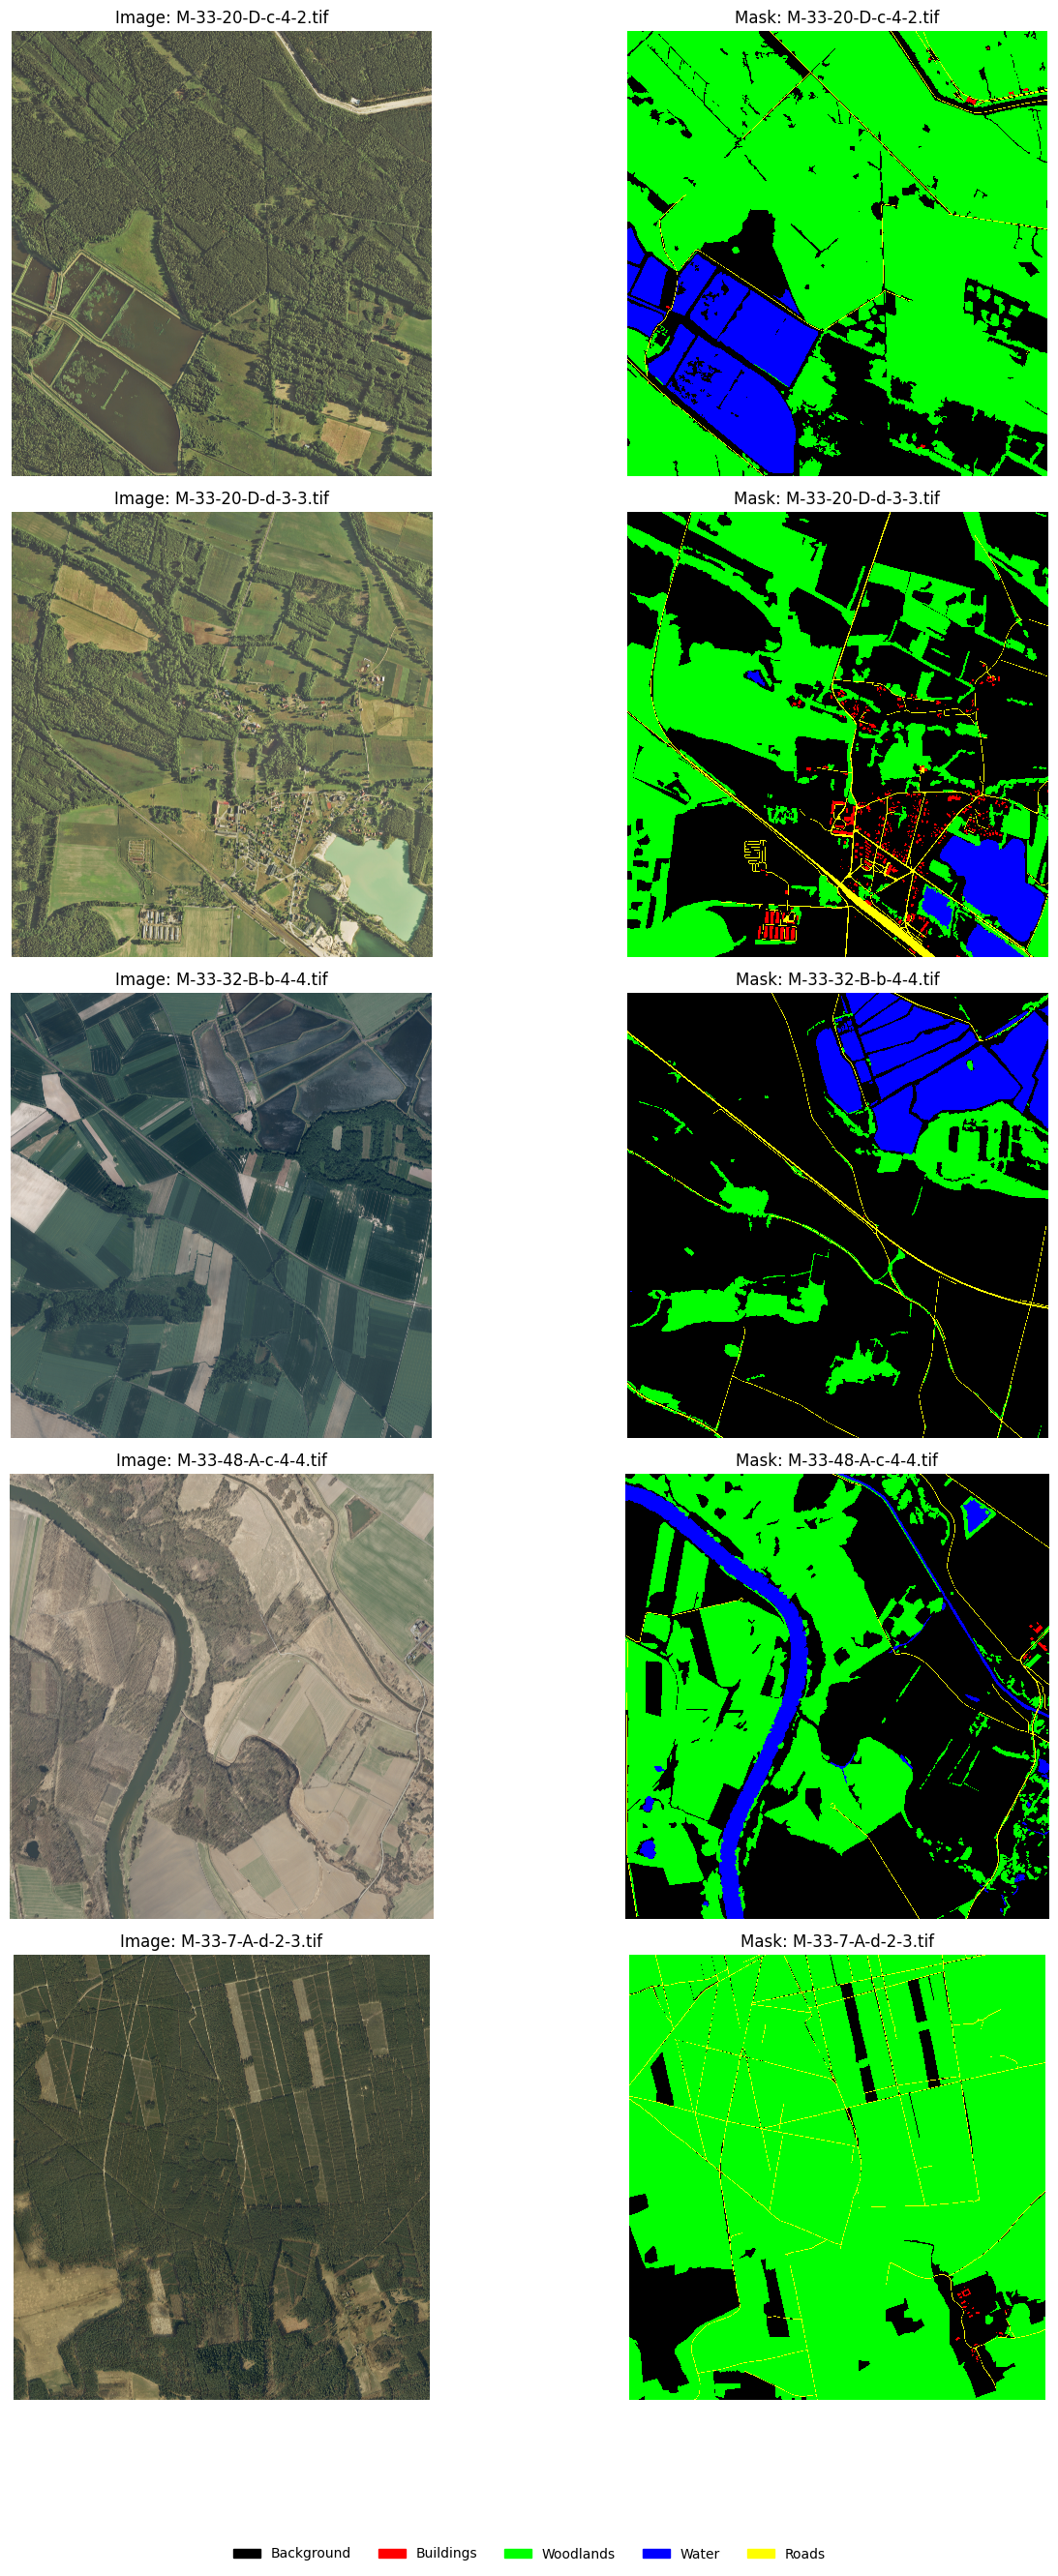

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Define paths to images and masks
images_dir = "/content/landcover_ai/images"  # Adjust if the folder structure is different
masks_dir = "/content/landcover_ai/masks"

# Define class names and corresponding colors
class_names = ["Background", "Buildings", "Woodlands", "Water", "Roads"]
class_colors = [
    (0, 0, 0),        # Black for Background
    (255, 0, 0),      # Red for Buildings
    (0, 255, 0),      # Green for Woodlands
    (0, 0, 255),      # Blue for Water
    (255, 255, 0),    # Yellow for Roads
]
cmap = ListedColormap(np.array(class_colors) / 255.0)  # Normalize colors to [0, 1]

# Function to display a sample of images and masks with legend
def visualize_samples_with_labels(images_dir, masks_dir, num_samples=5):
    image_files = os.listdir(images_dir)
    mask_files = os.listdir(masks_dir)

    # Sort to align images and masks correctly
    image_files.sort()
    mask_files.sort()

    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        # Load image
        img_path = os.path.join(images_dir, image_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for visualization

        # Load mask
        mask_path = os.path.join(masks_dir, mask_files[i])
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Plot image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(img)
        plt.title(f"Image: {image_files[i]}")
        plt.axis("off")

        # Plot mask with mapped colors
        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(mask, cmap=cmap, interpolation="nearest")
        plt.title(f"Mask: {mask_files[i]}")
        plt.axis("off")

    # Add a legend for class mapping
    legend_patches = [Patch(color=np.array(color) / 255.0, label=name) for color, name in zip(class_colors, class_names)]
    plt.figlegend(handles=legend_patches, loc="upper center", ncol=len(class_names), bbox_to_anchor=(0.5, -0.05), frameon=False)

    plt.tight_layout()
    plt.show()

# Visualize a few samples
visualize_samples_with_labels(images_dir, masks_dir, num_samples=5)

# Preprocessing

In [8]:
# Check unique values in raw masks
import os
import cv2
import numpy as np

masks_dir = "/content/landcover_ai/masks"  # Path to masks directory

all_values = set()
for mask_name in os.listdir(masks_dir):
    mask_path = os.path.join(masks_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    all_values.update(np.unique(mask).tolist())

print(f"Unique mask values in raw files: {sorted(all_values)}")

Unique mask values in raw files: [0, 1, 2, 3, 4]


In [24]:
from tensorflow.keras.utils import to_categorical
import cv2
import os
import numpy as np

# Define preprocessing parameters
IMG_SIZE = (224, 224)  # Input image resolution
NUM_CLASSES = 5        # Number of segmentation classes


def preprocess_data(images_dir, masks_dir):
    images = []
    masks = []

    for img_name in os.listdir(images_dir):
        img_path = os.path.join(images_dir, img_name)
        mask_path = os.path.join(masks_dir, img_name.replace(".jpg", ".png"))  # Adjust extensions if needed

        # Load and resize image
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)  # Ensure the input image matches the model's input size
        img = img / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)

        # Load and validate mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Error: Mask not found or unreadable for {mask_path}")
            continue
        mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)  # Ensure consistent shape
        masks.append(mask)

    # Convert lists to numpy arrays
    images = np.array(images)
    masks = np.array(masks, dtype=np.uint8)  # Ensure integer type for masks

    # Convert masks to one-hot encoding
    masks_one_hot = to_categorical(masks, num_classes=NUM_CLASSES)

    return images, masks_one_hot

# Example usage
images, masks = preprocess_data(images_dir, masks_dir)

# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}, {y_train.shape}")
print(f"Test Data Shape: {X_test.shape}, {y_test.shape}")


Training Data Shape: (32, 224, 224, 3), (32, 224, 224, 5)
Test Data Shape: (9, 224, 224, 3), (9, 224, 224, 5)


In [35]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, Input

# Access the feature extraction portion of the base model
feature_extractor = Model(inputs=Base_Model.input, outputs={
    "block1_pool": Base_Model.get_layer("block1_pool").output,
    "block2_pool": Base_Model.get_layer("block2_pool").output,
    "block3_pool": Base_Model.get_layer("block3_pool").output,
    "block4_pool": Base_Model.get_layer("block4_pool").output,
    "block5_pool": Base_Model.get_layer("block5_pool").output,
})

# Input layer
inputs = Input(shape=(224, 224, 3))

# Encoder: Pass through the pre-trained layers
encoder_outputs = feature_extractor(inputs)

# Decoder with Skip Connections
x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(encoder_outputs["block5_pool"])
x = concatenate([x, encoder_outputs["block4_pool"]])  # Skip connection
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
x = concatenate([x, encoder_outputs["block3_pool"]])  # Skip connection
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = concatenate([x, encoder_outputs["block2_pool"]])  # Skip connection
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
x = concatenate([x, encoder_outputs["block1_pool"]])  # Skip connection
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# Add a final upsampling layer to match input resolution (224x224)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)

# Final Output Layer for Segmentation
outputs = Conv2D(5, (1, 1), activation='softmax')(x)  # 5 classes with softmax activation

# Final Segmentation Model
segmentation_model = Model(inputs, outputs)


from tensorflow.keras.optimizers import Adam

# Set a custom learning rate
custom_learning_rate = 0.0001  # Example: Lower learning rate
segmentation_model.compile(optimizer=Adam(learning_rate=custom_learning_rate),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Model summary
segmentation_model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_8 (Functional) │ [(None, 112, 112, 64), │     14,714,688 │ input_layer_4[0][0]    │
│                           │ (None, 56, 56, 128),   │                │                        │
│                           │ (None, 28, 28, 256),   │                │                        │
│                           │ (None, 14, 14, 512),   │                │                        │
│                           │ (None, 7, 7, 512)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_18       │ (None, 14, 14, 512)    │      2,359,808 │ functional_8[0][4]     │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_16            │ (None, 14, 14, 1024)   │              0 │ conv2d_transpose_18[0… │
│ (Concatenate)             │                        │                │ functional_8[0][3]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 14, 14, 512)    │      4,719,104 │ concatenate_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_19       │ (None, 28, 28, 256)    │      1,179,904 │ conv2d_20[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 28, 28, 512)    │              0 │ conv2d_transpose_19[0… │
│ (Concatenate)             │                        │                │ functional_8[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 28, 28, 256)    │      1,179,904 │ concatenate_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_20       │ (None, 56, 56, 128)    │        295,040 │ conv2d_21[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_18            │ (None, 56, 56, 256)    │              0 │ conv2d_transpose_20[0… │
│ (Concatenate)             │                        │                │ functional_8[0][1]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 56, 56, 128)    │        295,040 │ concatenate_18[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_21       │ (None, 112, 112, 64)   │         73,792 │ conv2d_22[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_19            │ (None, 112, 112, 128)  │              0 │ conv2d_transpose_21[0… │
│ (Concatenate)             │                        │                │ functional_8[0][0]     │
├──────────────────────

 Total params: 24,928,325 (95.09 MB)

 Trainable params: 24,928,325 (95.09 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
print(f"Model Input Shape: {segmentation_model.input_shape}")
print(f"Model Output Shape: {segmentation_model.output_shape}")
print(f"Training Data Shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test Data Shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Model Input Shape: (None, 224, 224, 3)
Model Output Shape: (None, 224, 224, 5)
Training Data Shape: X_train: (32, 224, 224, 3), y_train: (32, 224, 224, 5)
Test Data Shape: X_test: (9, 224, 224, 3), y_test: (9, 224, 224, 5)


In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = segmentation_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=4,
    epochs=40,
    callbacks=[lr_scheduler],
    verbose=1
)

Epoch 1/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step - accuracy: 0.0830 - loss: 1.8363 - val_accuracy: 0.3954 - val_loss: 1.5266 - learning_rate: 1.0000e-04
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.3959 - loss: 1.4879 - val_accuracy: 0.5787 - val_loss: 1.2323 - learning_rate: 1.0000e-04
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.5217 - loss: 1.2006 - val_accuracy: 0.5980 - val_loss: 1.0992 - learning_rate: 1.0000e-04
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.5917 - loss: 0.9896 - val_accuracy: 0.6625 - val_loss: 1.0696 - learning_rate: 1.0000e-04
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.6464 - loss: 0.9369 - val_accuracy: 0.6755 - val_loss: 1.0446 - learning_rate: 1.0000e-04
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.6682 - loss: 0.9081 - val_accuracy: 0.7014 - val_loss: 0.9936 - learning_rate: 1.0000e-04
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.7880 - loss

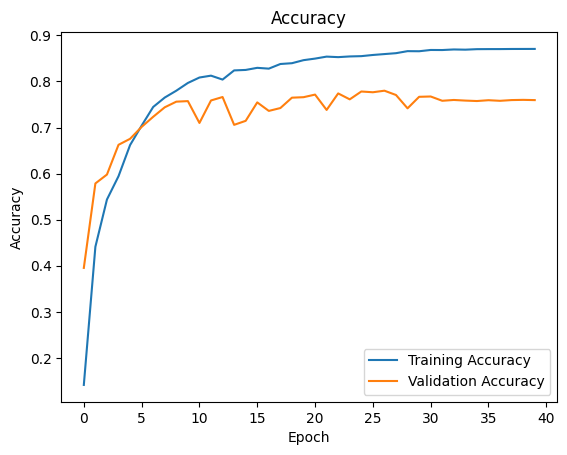

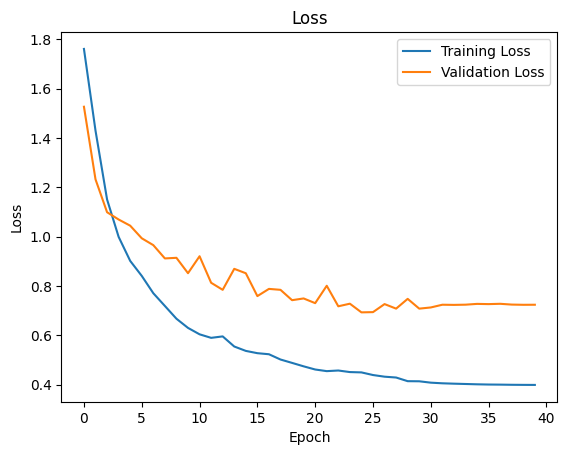

In [38]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
# Evaluate the model
loss, accuracy = segmentation_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - accuracy: 0.7595 - loss: 0.7243
Test Loss: 0.7242832779884338, Test Accuracy: 0.7595308423042297


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


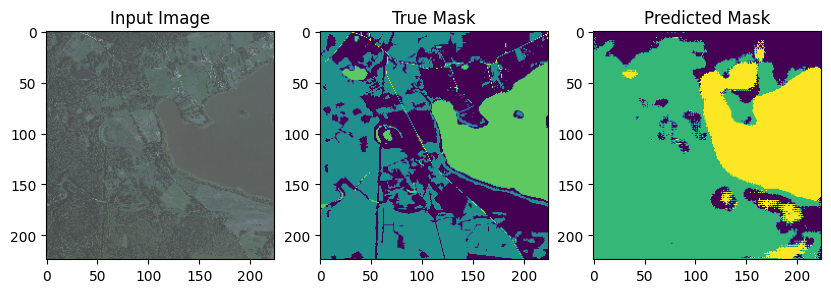

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


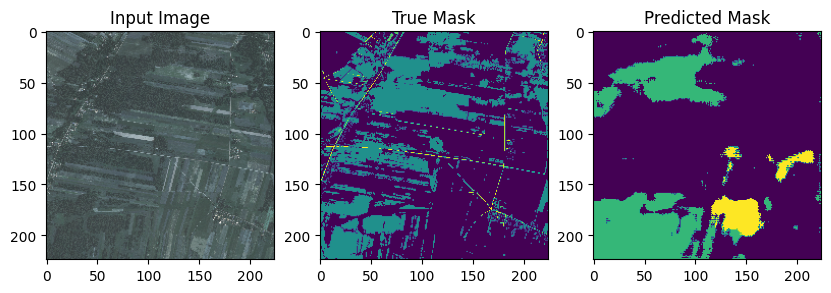

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


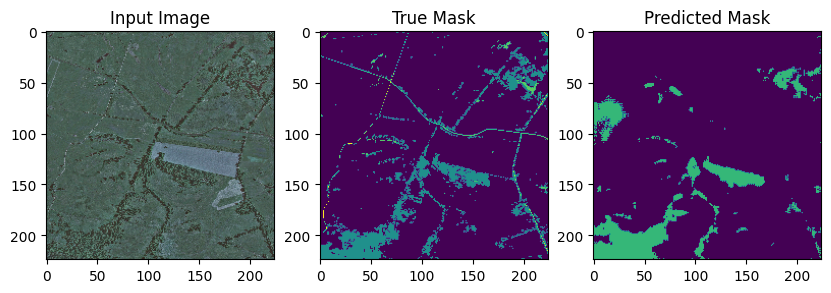

In [40]:
# Visualize predictions
import numpy as np

for i in range(3):  # Visualize first 3 samples
    sample_image = X_test[i]
    sample_mask = y_test[i]
    predicted_mask = segmentation_model.predict(sample_image[np.newaxis, ...])[0]

    # Convert one-hot encoded masks to class indices
    true_mask = np.argmax(sample_mask, axis=-1)
    pred_mask = np.argmax(predicted_mask, axis=-1)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(sample_image)

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(true_mask)

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask)

    plt.show()


In [41]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the model
model_save_path = '/content/drive/MyDrive/LandCover_Segmentation_Model.keras'

# Save the model
segmentation_model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved at: /content/drive/MyDrive/LandCover_Segmentation_Model.keras
